In [8]:
import os
import sys

import numpy as np
import magenpy as mgp
import pandas as pd
import matplotlib.pyplot as plt

import xarray
import zarr
import dask.array as da
import scipy
import subprocess

The following code is for selecting a number of SNPS, since the whole dataset has 12 million.

In [5]:
out_markers_file = "1000genomes/selected_snps"

In [2]:
bim_columns = ['Chromosome', 'SNP_ID', 'Genetic_Distance', 'BP_Position', 'Allele_1', 'Allele_2']
bimfile = pd.read_table("1000genomes/1000g.bim", names=bim_columns)

In [3]:
bimfile.shape

(12123481, 6)

In [6]:
num_snps_to_select = 20000
index = np.random.choice(np.arange(bimfile.shape[0]), num_snps_to_select, replace=False)
index.sort()
selected_snps = bimfile["SNP_ID"].to_numpy()[index].flatten()
markers_file = f"{out_markers_file}_{int(num_snps_to_select/1000)}K.txt"
np.savetxt(markers_file, selected_snps, fmt='%s')

We have saved the markers in a txt file. The following code is for calling plink and creating the files with only the SNPs we have selected. For this to work you have to put the plink executable on the bin folder and give it writing and reading permissions. 

In [7]:
bfile_name = "1000genomes/1000g"
output_name = f"1000genomes/1000g_{int(num_snps_to_select/1000)}K"
markers_file = f"{out_markers_file}_{int(num_snps_to_select/1000)}K.txt"
plink_command = ["plink1.9", "--bfile", bfile_name, "--extract", markers_file, "--make-bed","--out", output_name]

process = subprocess.Popen(plink_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)

stdout, stderr = process.communicate()

## error handling
if process.returncode == 0:
    pass
else:
    print("PLINK command encountered an error.")
    print("Standard Output:")
    print(stdout)
    print("Standard Error:")
    print(stderr)

Now we load this data with the magenpy package to create the LD matrix. I couldn't get it to work with plink. But if we want to do it later we should load the data with `backend="plink"`.

In [9]:
## indicate where the plink executables are
mgp.set_option("plink1.9_path", "/usr/local/bin/plink1.9")
mgp.set_option("plink2_path", "/usr/local/bin/plink2")

In [10]:
gdl = mgp.GWADataLoader('1000genomes/1000g_20K')

> Reading BED file...


The following command creates one matrix for every chromosome. I don't think there is a way to do it for every pair of markers with this package. But we could try to do it with plink directly. In this case using `estimator='sample'` we are computing the value for every pair of markers in the chromosome.

In [11]:
gdl.compute_ld(estimator='sample',
               output_dir='output/')

Computing LD matrices: 100%|████████████████████| 22/22 [00:04<00:00,  4.42it/s]


Now we convert every matrix into a sparse matrix with the `to_csr_matrix()` command. We can put these matrices together in a "diagonal" matrix by blocks. 

In [12]:
matrices = [m.to_csr_matrix() for m in gdl.ld.values()]

In [13]:
LD_matrix = scipy.sparse.tril(scipy.sparse.block_diag(matrices))

In [22]:
scipy.sparse.save_npz("LDmatrix_20K.npz", LD_matrix)

In [14]:
sys.getsizeof(LD_matrix)

48

So the size of the LD matrix is 48 bytes. I know this doesn't make any sense. We check the dimensions and the data type.

In [16]:
LD_matrix.shape, LD_matrix.dtype

((20000, 20000), dtype('float64'))

Everything is correct. Then if we convert it to a numpy array and check the size...

In [19]:
print(sys.getsizeof(LD_matrix.toarray()) * 1e-9, " GB")

3.200000128  GB


We can also save the matrix in a npz file (it was the format I found in the documentation). Then the size is bigger.

In [20]:
print(os.path.getsize("LDmatrix_20K.npz")*1e-6, " MB")

47.699148  MB


We plot the matrix to see if it makes any sense.

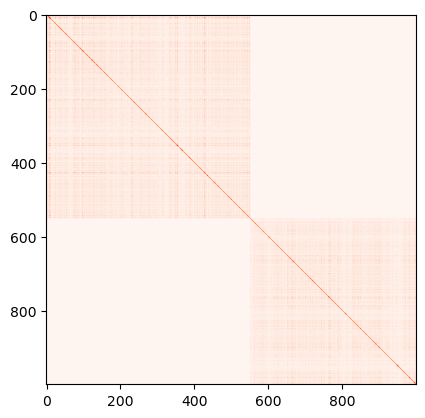

In [10]:
plt.imshow(np.abs(LD_matrix.toarray()[1000:2000,1000:2000]), cmap="Reds")

It makes sense to have blocks by chromosome.